# PIB Dataset

The script below aims to apply different models of time series analysis to predict values.

The time series in question is the Gross Domestic Product (GDP) of Brazil, which includes monthly data from the year 2004 until the present day.

The models will be adjusted using data from 2004 until the last month of 2020 to make predictions from 2021 onwards.

Furthermore, a second training of the models will be conducted, excluding the data from the initial months of the year 2020 (disregarding the effects of the early months of the COVID pandemic on Brazil).

### Checking Dataset

In [1]:
# Libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs
import warnings

warnings.filterwarnings("ignore")
sns.set()

In [2]:
# Dataset values
df_pib = pd.read_csv(f'Data/PIB.csv', index_col = 0)
df_pib.head(5)

,Data,pib
0,2004-01-01,144558.6
1,2004-02-01,142861.3
2,2004-03-01,157363.5
3,2004-04-01,156953.9
4,2004-05-01,159498.9


In [3]:
# Transforming the date column
df_pib['Data'] = pd.to_datetime(df_pib['Data'])

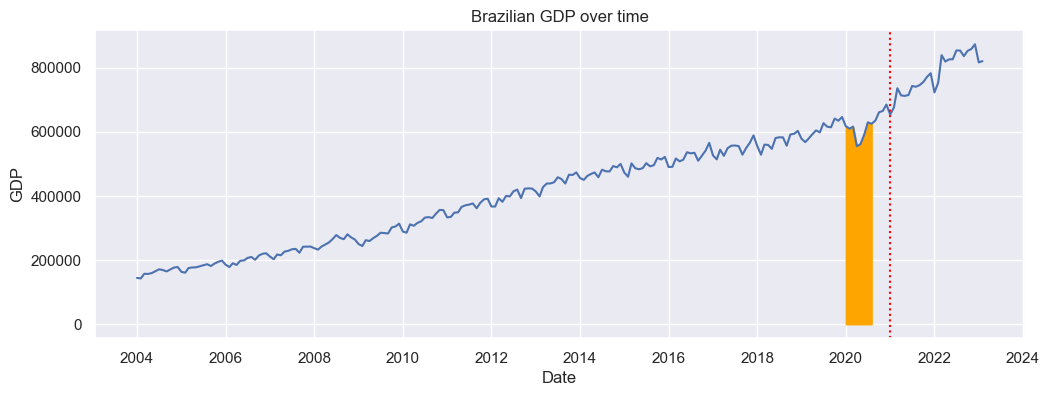

In [4]:
# Plotting the PIB over time
start_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2020, 8, 1)
plt.figure(figsize=(12,4))
plt.plot(df_pib['Data'], df_pib['pib'])
plt.xlabel('Date')
plt.ylabel('GDP')
plt.title('Brazilian GDP over time')
plt.fill_between(df_pib['Data'], df_pib['pib'], where=((df_pib['Data'] >= start_date) & (df_pib['Data'] <= end_date)), color='orange')
plt.axvline(dt.datetime(2021, 1, 1), color='red', linestyle='dotted');

The graph illustrates the trend of the Brazilian GDP over the years, beginning in 2004.

The dashed line marks the date from which the models will make predictions.

The shaded orange area corresponds to the initial months of the COVID pandemic, showing a noticeable deviation in the data pattern. This specific time window will be disregarded during a subsequent model adjustment.

In [5]:
# Decomposing the time series
decomposed_ts = sm.tsa.seasonal_decompose(df_pib['pib'], period=12)

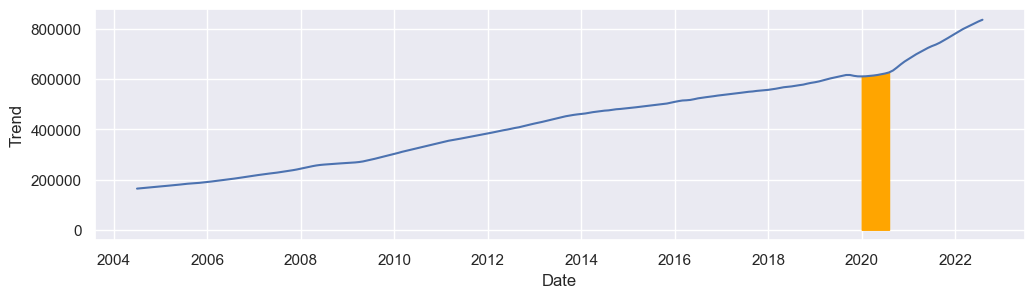

In [6]:
# Plotting the Trend
plt.figure(figsize=(12,3))
plt.plot(df_pib['Data'], decomposed_ts.trend)
plt.xlabel('Date')
plt.ylabel('Trend')
plt.fill_between(df_pib['Data'], decomposed_ts.trend, where=((df_pib['Data'] >= start_date) & (df_pib['Data'] <= end_date)), color='orange')
plt.show();

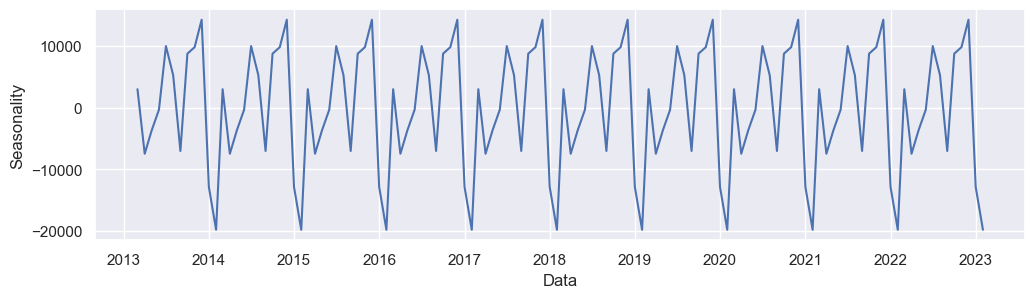

In [7]:
# Plotting the Seasonality
plt.figure(figsize=(12,3))
plt.plot(df_pib['Data'][len(df_pib)-120:], decomposed_ts.seasonal[len(df_pib)-120:])
plt.xlabel('Data')
plt.ylabel('Seasonality')
plt.show();

### Creating and  Adjusting Exponential Smoothing Models

Based on the charts, it is evident that there is an annual seasonal pattern along with a positive trend (A slight downward pattern can be observed during 2020). Therefore, the Holt-Winters model is likely to provide the most accurate predictions.

In [8]:
# Splitting the dataset on test and train (considering a point where the dataframe will be divided)
split_index = df_pib.loc[df_pib['Data']==dt.datetime(2021,1,1)].index[0]
df_train = df_pib['pib'].loc[:split_index]
df_test = df_pib['pib'].loc[split_index+1:]

In [9]:
# SES Model
model_ses = sm.tsa.SimpleExpSmoothing(df_train, initialization_method='estimated')
model_ses = model_ses.fit()
model_ses.summary()

Dep. Variable:,pib,No. Observations:,205
Model:,SimpleExpSmoothing,SSE,46031489815.797
Optimized:,True,AIC,3946.064
Trend:,None,BIC,3952.710
Seasonal:,None,AICC,3946.264
Seasonal Periods:,None,Date:,"Fri, 19 May 2023"
Box-Cox:,False,Time:,17:58:51
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7183891,alpha,True
initial_level,1.4524e+05,l.0,True


In [10]:
# Holt Linear Model
model_holt = Holt(df_train, damped_trend=False, initialization_method='estimated')
model_holt = model_holt.fit()
model_holt.summary()

Dep. Variable:,pib,No. Observations:,205
Model:,Holt,SSE,43000243250.092
Optimized:,True,AIC,3936.100
Trend:,Additive,BIC,3949.392
Seasonal:,None,AICC,3936.524
Seasonal Periods:,None,Date:,"Fri, 19 May 2023"
Box-Cox:,False,Time:,17:58:51
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5471429,alpha,True
smoothing_trend,0.0001,beta,True


In [11]:
# Model Holt Winter (Additive)
model_hw_add = ExponentialSmoothing(df_train, trend='add', seasonal='add', seasonal_periods=12, initialization_method='estimated')
model_hw_add = model_hw_add.fit()
model_hw_add.summary()

Dep. Variable:,pib,No. Observations:,205
Model:,ExponentialSmoothing,SSE,20831415716.440
Optimized:,True,AIC,3811.527
Trend:,Additive,BIC,3864.695
Seasonal:,Additive,AICC,3815.205
Seasonal Periods:,12,Date:,"Fri, 19 May 2023"
Box-Cox:,False,Time:,17:58:51
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7121429,alpha,True
smoothing_trend,0.0001,beta,True


In [12]:
# Model Holt Winter (Multiplicative)
model_hw_mul = ExponentialSmoothing(df_train, trend='mul', seasonal='mul', seasonal_periods=12, initialization_method='heuristic')
model_hw_mul = model_hw_mul.fit()
model_hw_mul.summary()

Dep. Variable:,pib,No. Observations:,205
Model:,ExponentialSmoothing,SSE,20064924466.934
Optimized:,True,AIC,3803.842
Trend:,Multiplicative,BIC,3857.010
Seasonal:,Multiplicative,AICC,3807.519
Seasonal Periods:,12,Date:,"Fri, 19 May 2023"
Box-Cox:,False,Time:,17:58:51
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7475000,alpha,True
smoothing_trend,0.0299000,beta,True


### Creating and Adjusting ARIMA Model

The ARIMA and SARIMA models require stationary data. From the time series plots of GDP, it is evident that there is no seasonality in the dataset. However, it is necessary to perform the Dickey-Fuller test to confirm stationarity.

In [13]:
# Dickey Fuller Test
adf_result = adfuller(df_pib['pib'], maxlag=1)
adf_result

(0.15784301799307843,
 0.969795511392327,
 1,
 228,
 {'1%': -3.4593607492757554,
  '5%': -2.8743015807562924,
  '10%': -2.5735714042782396},
 5097.93340221011)

A p-value of 0.97 in the Dickey-Fuller test indicates that there is no statistical evidence to reject the null hypothesis that the time series is non-stationary. In other words, such a high p-value suggests that the time series is non-stationary and exhibits some form of significant trend or pattern.

The main technique for addressing the stationarity of data in time series is differencing. Differencing involves calculating the differences between consecutive observations of the time series. This technique is used to remove trends and seasonal patterns, making the data more stationary.

In [14]:
# It needs to be differenced
diffs = ndiffs(df_pib['pib'], test='adf')
diffs

1

In [15]:
# Differencing
dif_df_train = np.diff(df_pib['pib'].loc[df_train.index])

The auto_arima method performs a search using the AIC criterion to find the best-fitting ARIMA model.

In [16]:
# Creating the ARIMA model
arima_model = auto_arima(dif_df_train, trace=True, seazonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=4418.758, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4511.396, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4423.913, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4425.662, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4514.829, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=4434.386, Time=0.22 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=4414.960, Time=0.32 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=4484.179, Time=0.14 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=4415.471, Time=0.46 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=4415.312, Time=0.19 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=4411.045, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=4492.371, Time=0.06 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=4409.574, Time=0.52 sec
 ARIMA(2,0,1)(2,0,1)[12]

In [17]:
# Fitting
arima_model.fit(dif_df_train)

ARIMA(order=(3, 0, 2), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True)

In [18]:
# Model Outputs
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  204
Model:             SARIMAX(3, 0, 2)x(2, 0, [], 12)   Log Likelihood               -2192.783
Date:                             Fri, 19 May 2023   AIC                           4403.565
Time:                                     17:59:10   BIC                           4433.429
Sample:                                          0   HQIC                          4415.646
                                             - 204                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6425.0074   4941.010      1.300      0.193   -3259.195    1.61e+04
ar.L1         -1.9901      0.183    -10.897      0.000      -2.348      -1.632
ar.L2         -1.3908      0.221     -6.294      0.000      -1.824      -0.958
ar.L3         -0.2959      0.096     -3.094      0.002      -0.483      -0.108
ma.L1          1.7639      0.146     12.095      0.000       1.478       2.050
ma.L2          0.8953      0.139      6.451      0.000       0.623       1.167
ar.S.L12       0.4638      0.133      3.487      0.000       0.203       0.724
ar.S.L24       0.2528      0.150      1.688      0.091      -0.041       0.546
sigma2      1.832e+08      0.016   1.16e+10      0.000    1.83e+08    1.83e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               362.59
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               8.20   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.71e+26. Standard errors may be unstable.
"""

### Checking Predictions and the Model's MAPE

In [19]:
# Creating a function to calculate the MAPE
def mape(serie):
    if type(serie) == pd.Series:
        return round((np.mean(abs((df_test.values-serie.values)/df_test.values))*100),2)
    elif type(serie) == np.ndarray:
         return round((np.mean(abs((df_test-serie)/df_test))*100),2)

# Creating a dataframe to list the values
df_mape = pd.DataFrame(index=['full data'], columns=['SES', 'Holt', 'HW (add)', 'HW (mul)', 'ARIMA'])

In [20]:
# Getting SES predictions
ses_predictions = model_ses.forecast(steps=len(df_test))
# Getting HOLT predictions
holt_predictions = model_holt.forecast(steps=len(df_test))
# Getting HW Add predictions
hw_add_predictions = model_hw_add.forecast(steps=len(df_test))
# Getting HW Multiplicative predictions
hw_mul_predictions = model_hw_mul.forecast(steps=len(df_test))

In [21]:
# Adding MAPE values
df_mape['SES'].loc['full data'] = mape(ses_predictions)
df_mape['Holt'].loc['full data'] = mape(holt_predictions)
df_mape['HW (add)'].loc['full data'] = mape(hw_add_predictions)
df_mape['HW (mul)'].loc['full data'] = mape(hw_mul_predictions)

In [25]:
# Getting Arima predictions
arima_predictions_dif = arima_model.predict(n_periods=len(df_test))
arima_predictions_dif

array([ -3226.39319328,  10339.44815473, -28131.30860335,  11761.96476196,
        10247.21480074,  28193.98361697,  -3789.68682109,   4591.87326685,
        22056.21125129,   -559.35636739,  15557.94517042, -21989.12704512,
        -1095.02505997,   7431.31222971, -27262.08345079,   9001.37763298,
        12870.90458111,  24947.77625482,  -2271.57586279,   6582.57672068,
        17882.78986053,   2154.67492321,  13782.18586097, -17018.52492799,
          389.01809594])

The ARIMA predictions are derived from differenced values, which are utilized to fit the model. To obtain the actual predicted values, these differenced values need to be reversed through an inverse process.

In [26]:
# Getting the train database last value
train_last_value = df_pib['pib'].loc[split_index]
# Getting the reversed predictions
arima_predictions = np.r_[train_last_value, arima_predictions_dif].cumsum()[1:]

In [27]:
# Adding ARIMA MAPE
df_mape['ARIMA'].loc['full data'] = mape(arima_predictions)

In [28]:
# Checking MAPE values
df_mape

,SES,Holt,HW (add),HW (mul),ARIMA
full data,15.47,10.19,12.28,8.58,10.64


As we can observe, the Holt-Winters Multiplicative model yielded the best predictions with a MAPE of 8.6%. The ARIMA and Holt methods had similar MAPE values, both around 10%.

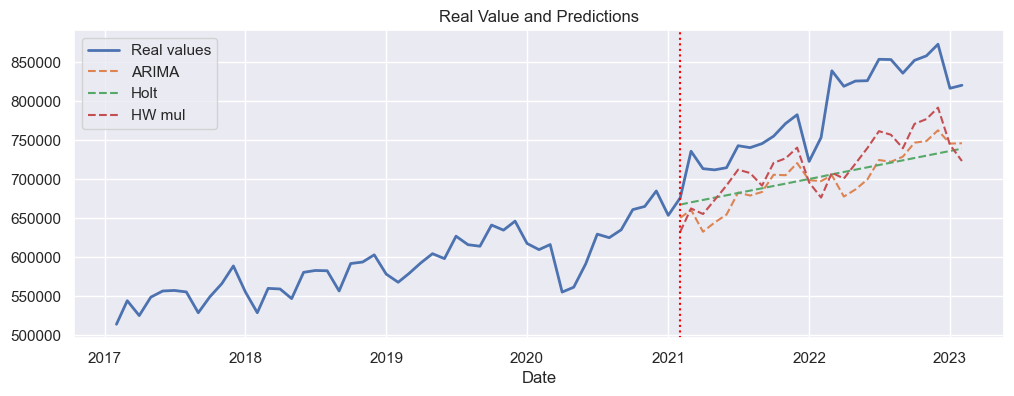

In [29]:
# Plotting the Retail Value and predictions after 2020
plt.figure(figsize=(12,4))
plt.plot(df_pib['Data'].loc[df_pib['Data']>dt.datetime(2017, 1, 1)], df_pib['pib'].loc[df_pib['Data']>dt.datetime(2017, 1, 1)], lw=2)
plt.plot(df_pib['Data'].loc[df_test.index], arima_predictions, linestyle='dashed')
plt.plot(df_pib['Data'].loc[df_test.index], holt_predictions, linestyle='dashed')
plt.plot(df_pib['Data'].loc[df_test.index], hw_mul_predictions, linestyle='dashed')
plt.legend(['Real values', 'ARIMA','Holt', 'HW mul'])
plt.xlabel('Date')
plt.title('Real Value and Predictions')
plt.axvline(dt.datetime(2021, 2, 1), color='red', linestyle='dotted')
plt.show();

As observed, the MAPE of the models showed a significant reduction with the new dataset.

The Holt Winter Multiplicative model once again achieved the best predictions, with the MAPE decreasing from 8.6% to 5%. The ARIMA model, which had previously performed well, had its MAPE reduced by almost half. However, the Holt model had a lower predictive performance after excluding the data.

This indicates that the removal of data from January to August 2020 positively influenced the prediction of the models. The best model predicts the data from January 2021 onwards with an average percentage error of 5%, which is superior to the 8% obtained without removing the data.

### Reapeating the Process

In [30]:
# max index
to_delete_dates = df_pib.loc[(df_pib['Data']>=dt.datetime(2020,1,1))&(df_pib['Data']<=dt.datetime(2020,8,1))].index

In [31]:
# Reduced train data
df_train_reduced = df_train.drop(to_delete_dates)

# Differencing
dif_df_train_reduced = np.diff(df_pib['pib'].loc[df_train_reduced.index])

In [32]:
# SES Model
model_ses2 = sm.tsa.SimpleExpSmoothing(df_train_reduced, initialization_method='estimated')
model_ses2 = model_ses2.fit()
model_ses2.summary()

Dep. Variable:,pib,No. Observations:,197
Model:,SimpleExpSmoothing,SSE,37832582467.364
Optimized:,True,AIC,3761.427
Trend:,None,BIC,3767.993
Seasonal:,None,AICC,3761.635
Seasonal Periods:,None,Date:,"Fri, 19 May 2023"
Box-Cox:,False,Time:,18:04:58
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6266279,alpha,True
initial_level,1.4374e+05,l.0,True


In [33]:
# Holt Linear Model
model_holt2 = Holt(df_train_reduced, damped_trend=False, initialization_method='estimated')
model_holt2 = model_holt2.fit()
model_holt2.summary()

Dep. Variable:,pib,No. Observations:,197
Model:,Holt,SSE,32393813802.527
Optimized:,True,AIC,3734.852
Trend:,Additive,BIC,3747.985
Seasonal:,None,AICC,3735.294
Seasonal Periods:,None,Date:,"Fri, 19 May 2023"
Box-Cox:,False,Time:,18:04:58
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3350000,alpha,True
smoothing_trend,0.0001,beta,True


In [34]:
# Model Holt Winter (Additive)
model_hw_add2 = ExponentialSmoothing(df_train_reduced, trend='add', seasonal='add', seasonal_periods=12, initialization_method='estimated')
model_hw_add2 = model_hw_add2.fit()
model_hw_add2.summary()

Dep. Variable:,pib,No. Observations:,197
Model:,ExponentialSmoothing,SSE,14706104474.288
Optimized:,True,AIC,3603.280
Trend:,Additive,BIC,3655.811
Seasonal:,Additive,AICC,3607.123
Seasonal Periods:,12,Date:,"Fri, 19 May 2023"
Box-Cox:,False,Time:,18:04:58
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3585714,alpha,True
smoothing_trend,0.0632773,beta,True


In [35]:
# Model Holt Winter (Multiplicative)
model_hw_mul2 = ExponentialSmoothing(df_train_reduced, trend='mul', seasonal='mul', seasonal_periods=12, initialization_method='heuristic')
model_hw_mul2 = model_hw_mul2.fit()
model_hw_mul2.summary()

Dep. Variable:,pib,No. Observations:,197
Model:,ExponentialSmoothing,SSE,16834547031.900
Optimized:,True,AIC,3629.909
Trend:,Multiplicative,BIC,3682.440
Seasonal:,Multiplicative,AICC,3633.751
Seasonal Periods:,12,Date:,"Fri, 19 May 2023"
Box-Cox:,False,Time:,18:04:58
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3232143,alpha,True
smoothing_trend,0.0606027,beta,True


In [36]:
# Creating the ARIMA model
arima_model2 = auto_arima(dif_df_train_reduced, trace=True, seazonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=4200.868, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4310.539, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4213.350, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4222.793, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4314.916, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=4213.305, Time=0.26 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=4199.403, Time=0.37 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=4275.593, Time=0.20 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=4200.719, Time=0.61 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=1.66 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=4166.927, Time=0.46 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=4279.983, Time=0.09 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=4196.798, Time=0.45 sec
 ARIMA(2,0,1)(1,0,1)[12] inte

In [37]:
# Fitting
arima_model2.fit(dif_df_train_reduced)

ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(1, 0, 0, 12),
      suppress_warnings=True)

In [38]:
# Model Outputs
arima_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  196
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 12)   Log Likelihood               -2077.464
Date:                             Fri, 19 May 2023   AIC                           4166.927
Time:                                     18:05:08   BIC                           4186.596
Sample:                                          0   HQIC                          4174.890
                                             - 196                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4979.4368   1242.867      4.006      0.000    2543.462    7415.411
ar.L1         -1.3336      0.083    -16.021      0.000      -1.497      -1.170
ar.L2         -0.4668      0.062     -7.564      0.000      -0.588      -0.346
ma.L1          0.9258      0.053     17.483      0.000       0.822       1.030
ar.S.L12       0.6938      0.048     14.404      0.000       0.599       0.788
sigma2        8.9e+07      0.033    2.7e+09      0.000     8.9e+07     8.9e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):                42.38
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               5.66   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.83e+24. Standard errors may be unstable.
"""

In [39]:
# Getting SES predictions
ses_predictions2 = model_ses2.forecast(steps=len(df_test))
# Getting HOLT predictions
holt_predictions2 = model_holt2.forecast(steps=len(df_test))
# Getting HW Add predictions
hw_add_predictions2 = model_hw_add2.forecast(steps=len(df_test))
# Getting HW Multiplicative predictions
hw_mul_predictions2 = model_hw_mul2.forecast(steps=len(df_test))
# Getting Arima predictions
arima_predictions_dif2 = arima_model2.predict(n_periods=len(df_test))
# Getting the train database last value
train_last_value = df_train_reduced.loc[max(df_train_reduced.index)]
# Getting the reversed predictions
arima_predictions2 = np.r_[train_last_value, arima_predictions_dif2].cumsum()[1:]

In [40]:
# Adding MAPE values
df_mape['SES'].loc['reduced data'] = mape(ses_predictions2)
df_mape['Holt'].loc['reduced data'] = mape(holt_predictions2)
df_mape['HW (add)'].loc['reduced data'] = mape(hw_add_predictions2)
df_mape['HW (mul)'].loc['reduced data'] = mape(hw_mul_predictions2)
df_mape['ARIMA'].loc['reduced data'] = mape(arima_predictions2)

In [41]:
# checking MAPE values
df_mape

,SES,Holt,HW (add),HW (mul),ARIMA
full data,15.47,10.19,12.28,8.58,10.64


As observed, the MAPE of the models showed a significant reduction with the new dataset.

The Holt Winter Multiplicative model once again achieved the best predictions, with the MAPE decreasing from 8.6% to 5%. The ARIMA model, which had previously performed well, had its MAPE reduced by almost half. However, the Holt model had a lower predictive performance after excluding the data.

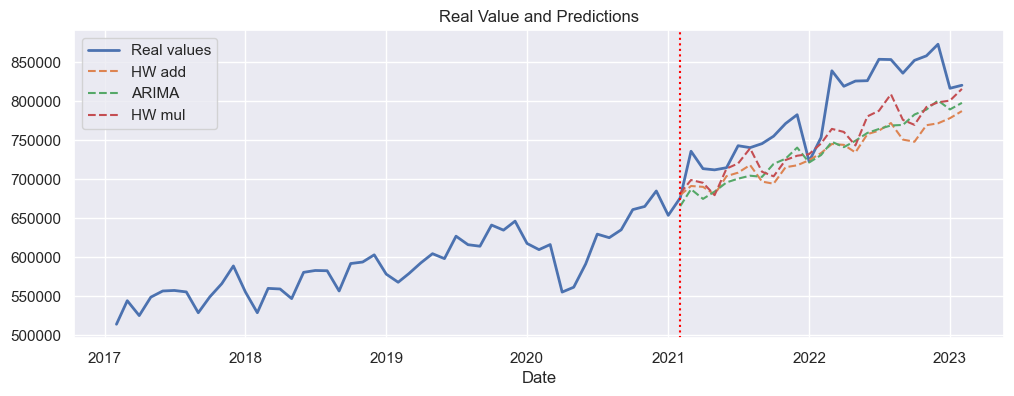

In [42]:
# Plotting the Retail Value and predictions after 2020
plt.figure(figsize=(12,4))
plt.plot(df_pib['Data'].loc[df_pib['Data']>dt.datetime(2017, 1, 1)], df_pib['pib'].loc[df_pib['Data']>dt.datetime(2017, 1, 1)], lw=2)
plt.plot(df_pib['Data'].loc[df_test.index], hw_add_predictions2, linestyle='dashed')
plt.plot(df_pib['Data'].loc[df_test.index], arima_predictions2, linestyle='dashed')
plt.plot(df_pib['Data'].loc[df_test.index], hw_mul_predictions2, linestyle='dashed')
plt.legend(['Real values', 'HW add','ARIMA', 'HW mul'])
plt.xlabel('Date')
plt.title('Real Value and Predictions')
plt.axvline(dt.datetime(2021, 2, 1), color='red', linestyle='dotted')
plt.show();


Observing the graph and comparing it to the previous one, it is possible to notice that an atypical period, such as the initial months of the COVID-19 pandemic, can have a significant impact on time series models, and excluding it can improve the predictive performance of the model.

However, this approach does not work in all cases, so it is essential to test different configurations when building models in order to find the one that best fits the data and provides the most accurate predictions.

The final conclusion is that the time series models were able to make good predictions for the last two years of the Brazilian GDP, especially when excluding the first months of 2020 from the dataset.